## Installation

Python 3 Required

In [22]:
!pip install installations/pyjnius-1.2.0-cp36-cp36m-win_amd64.whl
!pip2 install networkx, matplotlib, flair

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
ERROR: Invalid requirement: 'networkx,'

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## Text to Name

In [1]:
from flair.data import Sentence

In [2]:
from flair.models import SequenceTagger
from segtok.segmenter import split_single

# load the NER tagger
tagger = SequenceTagger.load('ner')

2019-10-20 19:43:39,565 loading file C:\Users\Hp\.flair\models\en-ner-conll03-v0.4.pt


In [3]:
def namesAndSentences(text):
    sentences_obj = [Sentence(sent, use_tokenizer=True) for sent in split_single(text)]
    tagger: SequenceTagger = SequenceTagger.load('ner')
    tagger.predict(sentences_obj)
    tegged_sentences = tagger.predict(sentences_obj)
    #name_gender = {}
    sentences = []
    male_names = []
    female_names = []
    for tagged_sent in tegged_sentences:
        sent_dict = tagged_sent.to_dict(tag_type='ner')
        sentences += [sent_dict['text']]
        if sent_dict['entities']:
            for entity in sent_dict['entities']:
                if entity['type'] == 'PER':
                    name = entity['text']
                    gender = isMale(name)
                    #name_gender[name] = gender
                    if gender:
                        male_names.append(name)
                    else:
                        female_names.append(name)
                    print(name, gender)
    return male_names, female_names, sentences

In [4]:
def humanName(name, names):
    for x in names:
        if x in name:
            return True
    return False

In [5]:
def nameToNode(graph, male_names, female_names):
    male_nodes = []
    female_nodes  = []
    nodes = set([item for sublist in graph for item in sublist])
    for node in nodes:
        for male_name in male_names:
            if male_name in node:
                male_nodes.append(node)
        for female_name in female_names:
            if female_name in node:
                female_nodes.append(node)
    # check if intersection
    return male_nodes, female_nodes

## Name To Gender

In [1]:
# LOAD SAVED MODEL
from keras.models import load_model

#del model  # deletes the existing model
model = load_model('name2gender_model/char_rnn_hsc_model_0.h5')

Using TensorFlow backend.
W0315 06:49:10.942313 10320 deprecation_wrapper.py:119] From c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0315 06:49:11.037203 10320 deprecation_wrapper.py:119] From c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0315 06:49:11.068990 10320 deprecation_wrapper.py:119] From c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0315 06:49:11.207610 10320 deprecation_wrapper.py:119] From c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_wit

In [7]:
import json

with open('name2gender_model/char2idx.json', 'r') as fp:
    char2idx = json.load(fp)
    
with open('name2gender_model/idx2char.json', 'r') as fp:
    idx2char = json.load(fp)

In [8]:
import numpy as np
from keras.preprocessing import sequence

# Converts a name into vector
def name2vectorTest(name):
    name = name.lower()
    new_name = ""
    for char in name:
      if char in char2idx:
        new_name += char
    chars = list(new_name)
    vector = [ char2idx[c] for c in chars ]
    return np.array(vector)

# Converts names to fixed size tensor
def names2tensorTest(names, maxlen=25):
    namelist = [name2vectorTest(name) for name in names]
    return sequence.pad_sequences(np.array(namelist), maxlen=maxlen)  # root of all troubles

def name2gender(name):
  result = model.predict_classes(np.array(names2tensorTest([name.lower()])))[0][0]
  if result:
    print("Male")
  else:
    print("Female")
  
def isMale(name):
  result = model.predict_classes(np.array(names2tensorTest([name.lower()])))[0][0]
  return result

In [9]:
isMale("khaleesi")

0

## Get Triples

In [2]:
import os
os.environ['CLASSPATH'] = "miniepy/target/minie-0.0.1-SNAPSHOT.jar"

from jnius import autoclass

CoreNLPUtils = autoclass('de.uni_mannheim.utils.coreNLP.CoreNLPUtils')
AnnotatedProposition = autoclass('de.uni_mannheim.minie.annotation.AnnotatedProposition')
MinIE = autoclass('de.uni_mannheim.minie.MinIE')
StanfordCoreNLP = autoclass('edu.stanford.nlp.pipeline.StanfordCoreNLP')
String = autoclass('java.lang.String')

parser = CoreNLPUtils.StanfordDepNNParser()

In [11]:
def getTriples(sentences, names, human_only=True):
    graph = []
    labels = []

    for sentence in sentences:
        minie = MinIE(String(sentence), parser, 0)

        for ap in minie.getPropositions().elements():
            if ap is not None:
                triple = ap.getTripleAsString().replace("\"", "").strip().split("\t")
                if len(triple) == 3 and (not human_only or (humanName(triple[0], names) or humanName(triple[2], names))):
                    graph += [(triple[0], triple[2])]
                    labels += [triple[1]]
    return graph, labels

## Draw Graph

In [38]:
import networkx as nx
import matplotlib.pyplot as plt

def drawGraph(graph, labels, male_nodes, female_nodes):
    G = nx.DiGraph()

    G.add_edges_from(graph)

    graph_pos = nx.shell_layout(G)
    plt.figure(1,figsize=(12,12)) 

    nx.draw_networkx_nodes(G,graph_pos,
                           nodelist=male_nodes,
                           node_color='r',
                           node_size=5000,
                       alpha=0.8)
    nx.draw_networkx_nodes(G,graph_pos,
                           nodelist=female_nodes,
                           node_color='b',
                           node_size=5000,
                       alpha=0.8)

    nx.draw_networkx_edges(G, graph_pos, width=2, alpha=0.3,  edge_color='blue')
    nx.draw_networkx_labels(G, graph_pos, font_size=12, font_family='sans-serif')

    edge_labels = dict(zip(graph, labels))
    nx.draw_networkx_edge_labels(G, graph_pos, edge_labels=edge_labels)

    plt.show()

# Action

In [29]:
del male_names, female_names, sentences, graph, labels, male_nodes, female_nodes

In [40]:
def text2GenderGraph(input_text):
    male_names, female_names, sentences = namesAndSentences(input_text)
    graph, labels = getTriples(sentences, male_names+female_names, human_only=True)
    male_nodes, female_nodes = nameToNode(graph, male_names, female_names)
    
    print("Triples:")
    for x,y in zip(graph, labels):
        print(x[0],"-",y,"-",x[1])
    
    drawGraph(graph, labels, male_nodes, female_nodes)

In [41]:
input_text = "Actor Aayush Sharma and wife Arpita Khan Sharma, sister of Salman Khan, are expecting their second child together."

2019-10-20 20:15:18,571 loading file C:\Users\Hp\.flair\models\en-ner-conll03-v0.4.pt
Aayush Sharma 1
Arpita Khan Sharma 0
Salman Khan 1
Triples:
Aayush Sharma - is - Actor
Arpita Khan Sharma - is - wife
Aayush Sharma - is sister of - Salman Khan
Arpita Khan Sharma - is sister of - Salman Khan
Aayush Sharma - expecting - child
Arpita Khan Sharma - expecting - child


c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


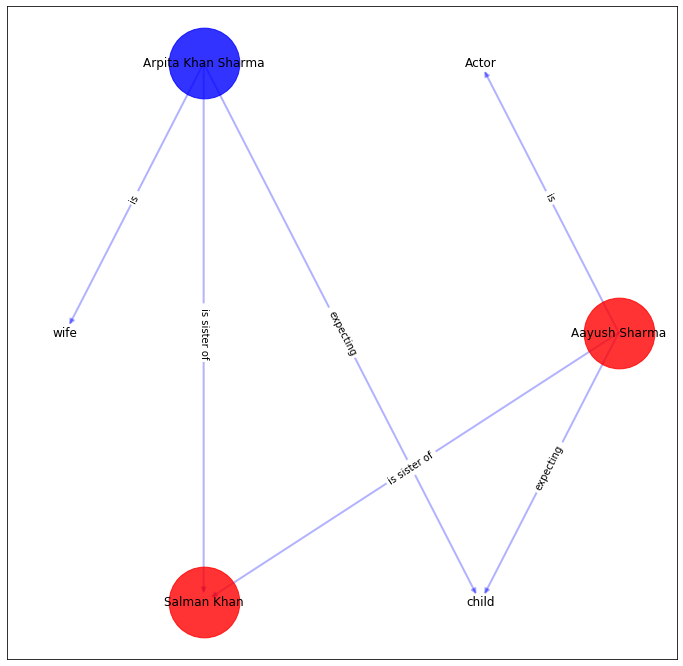

In [42]:
text2GenderGraph(input_text)